In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import os

run_analysis = False

sample_list = [
    "ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8",
    "ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8",
    "TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8",
    "TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8",
    "TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8",
]

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

In [2]:
if run_analysis:
    for s in sample_list:
        
        c = "time PYTHONPATH=.:$PYTHONPATH python3 simple_ttH.py --filelist datasets/" + s + ".txt --sample " + s + " --from-cache"
        os.system(c)

In [3]:
def merge_ttjets_output(samples):
    
    merge = {}
    for indx,s in enumerate(samples):
        with open(s) as json_file:
            data = json.load(json_file)
        
        for k1 in data.keys():
            if indx == 0:
                merge[k1] = {}
            for k2 in data[k1].keys():
                if k2 == "contents" and indx != 0:
                    merge[k1][k2] = [sum(x) for x in zip(merge[k1][k2], data[k1][k2])]
                else:
                    merge[k1][k2] = data[k1][k2]
    return merge
        

In [4]:
mc = merge_ttjets_output(["results/out_TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8.json", "results/out_TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.json", "results/out_TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8.json"])

with open("results/out_ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8.json") as json_file:
    mc.update(json.load(json_file))
with open("results/out_ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8.json") as json_file:
    mc.update(json.load(json_file))

data = merge_ttjets_output(["out_Run2017" + i + "_SingleElectron.json" for i in ["B", "C", "D", "E"]])

In [5]:
var_names = {
    "nbtags": "DeepCSV btag multiplicity",
    "njets" : "jet multiplicity",
    "leading_jet_pt" : "leading jet pt [GeV]",
    "leading_lepton_pt" : "leading lepton pt [GeV]",
    "genWeights" : "genWeights",
    "nElectrons" : "number of electrons",
    "nMuons" : "number of muons",
    "DNN": "DNN (binary classifier)",
    "nleps": "Number of leptons"
}

processes = ["ttHTobb", "ttHToNonbb", "ttlf", "ttbb", "tt2b","ttb", "ttcc"]
#processes = ["ttHTobb"]

process_names = {
    "ttHTobb" : "tt+H(bb)",
    "ttHToNonbb": "tt+H(non-bb)",
    "ttlf" : "tt+light",
    "ttbb" : "tt+bb",
    "tt2b" : "tt+2b",
    "ttb" : "tt+b",
    "ttcc" : "tt+cc",
    
}

colors = {
    "ttlf": (251, 102, 102),
    "ttcc": (204, 2, -0),
    "ttb": (153, 51, 51),
    "ttbb": (102, 0, 0),
    "tt2b": (80, 0, 0),
    "ttHTobb": (44, 62, 167),
    "ttHToNonbb": (90, 115, 203),
}

for cn, c in colors.items():
    colors[cn] = (c[0]/255.0, c[1]/255.0, c[2]/255.0)


In [6]:
def histogram_dataset(var, data, name, bottom, process):
    
    bins = data[var]["edges"][:-1]
    counts = data[var]["contents"]
    yerr = data[var]["contents_w2"]
        
    integral = sum(counts)
    width = bins[1] - bins[0]
    

    hist = plt.bar(bins, counts, width=width, bottom=bottom, align="edge", label=name + " ({0})".format(round(integral, 1)), color=colors[process], edgecolor=colors[process], zorder = 1000)
    #hist = plt.bar(bins, counts, yerr=yerr, width=width, align="center", label=dataset + " ({0})".format(round(integral, 2)))
    
    if process == "ttHTobb" and ("DNN" in var):
        bins = data[var]["edges"][1:]
        hist = plt.step(bins, [c*50 for c in counts], label="tt+H(bb) x 50", color=colors[process], where="pre")
        
    return plt.bar, counts

In [7]:
def plot_data(var, data):
    
    bins = data[var]["edges"][:-1]
    counts = data[var]["contents"]
    yerr = data[var]["contents_w2"]
        
    integral = sum(counts)
    width = bins[1] - bins[0]
    
    bin_centers = [i+width/2. for i in data[var]["edges"][:]]    

    #hist = plt.step(bins, counts, where="post", label="data ({0})".format(round(integral, 1)), color="k", zorder = 1001, markeredgecolor=None)
    hist = plt.plot(bin_centers, counts+[0.], "-o", drawstyle="steps-mid", label="data ({0})".format(round(integral, 1)), color="k", zorder = 1001)
    plt.xlim([data[var]["edges"][0], data[var]["edges"][-1]])
    #hist = plt.bar(bins, counts, yerr=yerr, width=width, align="center", label=dataset + " ({0})".format(round(integral, 2)))
        
    return plt.plot

In [8]:
def plot_histogram(var, processes, mc, data):
    
    bottom = None

    plt.grid(True, axis='y', zorder=0)
    for p in processes:
        _, counts = histogram_dataset("hist_" + p + "_" + var, mc, process_names[p], bottom, p)
        if processes.index(p) == 0:
            bottom = [0.0 for c in counts]
        bottom = [sum(x) for x in zip(bottom, counts)]
        
    plot_data("hist_data_" + var, data)
        
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=14)
    if var == "njets" or var == "nbtags":
        plt.yscale('log')
        plt.ylim([1,10**8])
    plt.xlabel(var_names[var], fontsize=18)
    plt.title(
        r"$\mathbf{CMS}$ private work",
        fontsize=16, x=0.01, ha="left", y=1.05, va="top")
    ax = plt.gca()
    plt.text(0.99, 0.98,
        "2017 pp $41.5\ \mathrm{fb}^{-1}\ \mathrm{(13\ TeV)}$",
              fontsize=12, ha="right", va="bottom", transform=ax.transAxes)


    
    plt.show()

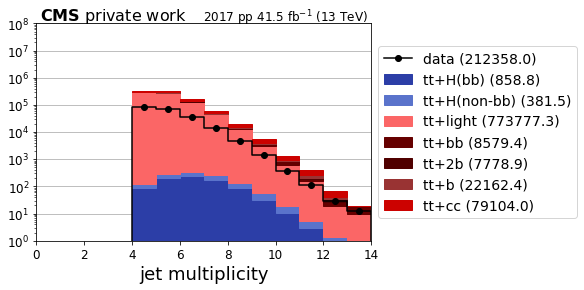

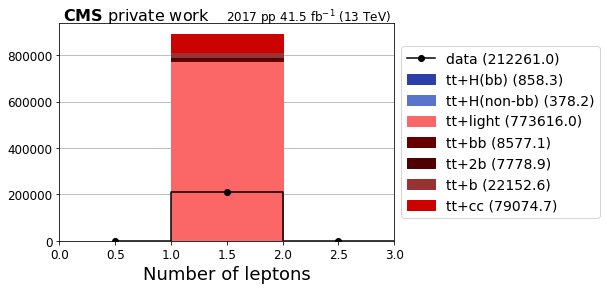

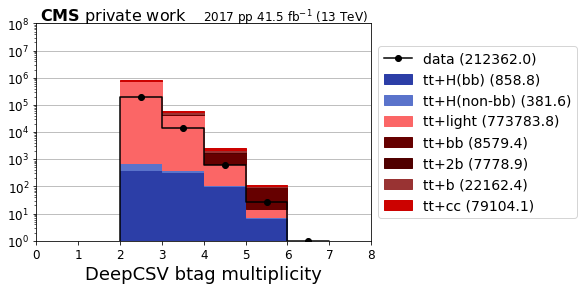

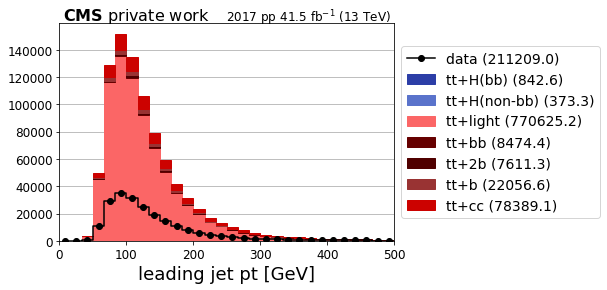

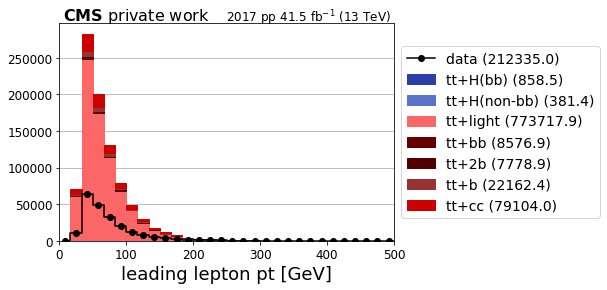

In [9]:
plot_histogram("njets", processes, mc, data)
plot_histogram("nleps", processes, mc, data)
plot_histogram("nbtags", processes, mc, data)
plot_histogram("leading_jet_pt", processes, mc, data)
plot_histogram("leading_lepton_pt", processes, mc, data)

# Calculation of stat. only result

In [10]:
def likelihood(mu, data_i, s_i, b_i):
    b_i[b_i < 0] = 0.0
    s_i[s_i < 0] = 0.0

    sel = ((s_i>0) & (b_i>0))
    
    ret = data_i[sel] * np.log(np.full(data_i.shape[0], mu)*s_i[sel] + b_i[sel]) - (mu*s_i[sel] + b_i[sel])
    return -np.sum(ret)

In [11]:
def make_fake_data(data, var, processes):
    
    # calculate total MC prediction
    for p in processes:
        if processes.index(p) == 0:
            counts = data["hist_" + p + "_" + var]["contents"]
        else:
            counts = [x + y for x, y in zip(counts, data["hist_" + p + "_" + var]["contents"])]
    
    return counts

In [12]:
def stat_fit(data, var, processes):
    
    fake_data = np.asarray(make_fake_data(data, var, processes))
    sig = np.asarray(data["hist_ttHTobb_" + var]["contents"])
    
    bkgs = [p for p in processes if p != "ttHTobb"]
    for p in bkgs:
        if bkgs.index(p) == 0:
            bkg_tot = data["hist_" + p + "_" + var]["contents"]
        else:
            bkg_tot = [x + y for x, y in zip(bkg_tot, data["hist_" + p + "_" + var]["contents"])]
    bkg_tot = np.asarray(bkg_tot)
    
    import scipy.optimize as optimize
    mu0 = 0.0
    res = optimize.minimize(likelihood, mu0, (fake_data, sig, bkg_tot), bounds = [(None,None)])

    # Error of estimator
    err = lambda mu: likelihood(mu, fake_data, sig, bkg_tot)-(likelihood(res.x, fake_data, sig, bkg_tot)+0.5)

    down = res.x - optimize.fsolve(err,(res.x - 3.0))[0]
    up = optimize.fsolve(err,(res.x + 0.01))[0] - res.x

    print("Best fit:", res.x[0], "-", down[0], "+", up[0])
    

In [13]:
stat_fit(mc, "DNN", processes)

KeyError: 'hist_ttHTobb_DNN'